In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC  
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_arrow_head, load_basic_motions

from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV

from sktime.datasets import load_arrow_head 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

In [2]:
# Opening up file containing GWAS data and reading in

file = open("GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

90

In [3]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]
df = pd.DataFrame(columns=columns)
i = 1
data = []
for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [4]:
# Sanity check to see if control SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "1"].value_counts()

rs2222162  PHENOTYPE
1          1            22
0          1            17
2          1             6
dtype: int64

In [5]:
# Sanity check to see if cases SNPs have been encoded correctly

df1 = df[["rs2222162","PHENOTYPE"]]
df1[df1["PHENOTYPE"] == "0"].value_counts()

rs2222162  PHENOTYPE
2          0            22
1          0            19
0          0             3
dtype: int64

In [6]:
# Only selecting 100 SNPs located on chromosome 2 

dfAlleles = df.loc[:, "rs11684739":"rs2521953"]
# dfAlleles = df.loc[:, "rs11684739":"rs6757306"] 500
dfInfo = df.loc[:, :"PHENOTYPE"]
df = dfInfo.join(dfAlleles)
len(df.columns)

106

In [7]:
# Fixing Phenotype values

df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [8]:
dfSave = df.copy(deep=True)

In [9]:
# Re-encoding SNP of interest to generate stronger signal

#df.loc[df.PHENOTYPE == "case", ["rs2222162"]] = "2"
#df.loc[df.PHENOTYPE == "control", ["rs2222162"]] = "0"

In [10]:
# Testing to see if amplifying singal increases accuracy

# df.insert(df.columns.get_loc("rs2222162"), "rs222216_1", df["rs2222162"])
# df.insert(df.columns.get_loc("rs2222162"), "rs222216_2", df["rs2222162"])
# df.insert(df.columns.get_loc("rs2222162"), "rs222216_3", df["rs2222162"])
# #df.insert(df.columns.get_loc("rs2222162"), "rs222216_4", df["rs2222162"])

In [11]:
# Removing ID columns and 

phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [12]:
# Replacing missing SNP entries and replacing with most frequent value for that SNP of other entries

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [13]:
# Converting columns to be numberical
idf = idf.apply(pd.to_numeric)

In [14]:
# Getting index of SNP of interest
idfT = idf.T

('control', 2)

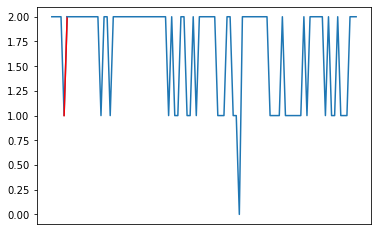

In [15]:
# Visualising entry 0 - control
position = idfT[0].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[0][0:position+1], color="tab:blue")
plt.plot(idfT[0][position-1:position+1], color="red")
plt.plot(idfT[0][position:],color="tab:blue")
phenotype[0], idfT[0][position]

('control', 0)

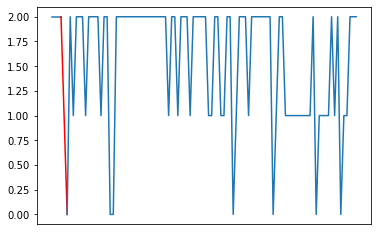

In [16]:
# Visualising entry 8 - control

position = idfT[8].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[8][0:position-1], color="tab:blue")
plt.plot(idfT[8][position-2:position+1], color="red")
plt.plot(idfT[8][position:],color="tab:blue")
phenotype[8], idfT[8][position]

('case', 2)

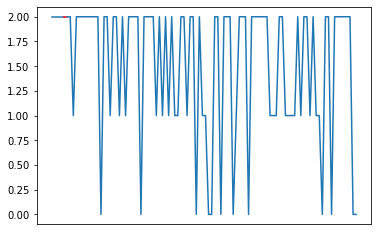

In [17]:
# Visualising entry 2 - case

position = idfT[2].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[2][0:position], color="tab:blue")
plt.plot(idfT[2][position-1:position+1], color="red")
plt.plot(idfT[2][position:],color="tab:blue")
phenotype[2], idfT[2][position]

('case', 1)

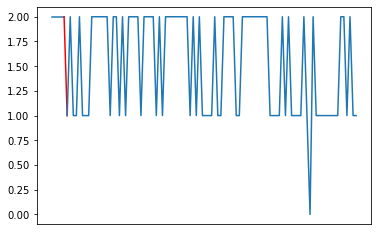

In [18]:
# Visualising entry 88 - case

position = idfT[88].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[88][0:position], color="tab:blue")
plt.plot(idfT[88][position-1:position+1], color="red")
plt.plot(idfT[88][position:],color="tab:blue")
phenotype[88], idfT[88][position]

In [19]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)

In [20]:
# Finding hyperparameters for RandomForst

# bootstrap = [True, False]
# maxDepth = list(range(10,110,10))
# maxFeatures = ["auto", "sqrt"]
# minSamplesLeaf = [1,2,3,4]
# minSamplesSplit = [2,3,5]
# nEstimators = list(range(100,1100,100))

# hyperparameters = dict(bootstrap=bootstrap, max_depth=maxDepth, max_features=maxFeatures, min_samples_leaf=minSamplesLeaf,
#                       min_samples_split=minSamplesSplit, n_estimators=nEstimators)

# rfd = RandomForestClassifier()

# clf = GridSearchCV(rfd, hyperparameters, cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best bootstrap:', bestModel.best_estimator_.get_params()['bootstrap'])
# print('Best max_depth:', bestModel.best_estimator_.get_params()['max_depth'])
# print('Best max_features:', bestModel.best_estimator_.get_params()['max_features'])
# print('Best min_samples_leaf:', bestModel.best_estimator_.get_params()['min_samples_leaf'])
# print('Best min_samples_split:', bestModel.best_estimator_.get_params()['min_samples_split'])
# print('Best n_estimators:', bestModel.best_estimator_.get_params()['n_estimators'])

In [21]:
# Classifying GWAS data using decision tree and printing results

rfc = RandomForestClassifier(bootstrap=True, max_depth=100, max_features="sqrt", 
                             min_samples_leaf=4, min_samples_split=2, n_estimators=100)
rfc.fit(xTrain, yTrain)
yPredicted = rfc.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = rfc.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))
print(classification_report(yTest, yPredicted))

Training accuracy score: 1.0
Testing accuracy score: 0.5555555555555556
[[ 8 13]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.73      0.38      0.50        21
     control       0.48      0.80      0.60        15

    accuracy                           0.56        36
   macro avg       0.60      0.59      0.55        36
weighted avg       0.62      0.56      0.54        36



<BarContainer object of 10 artists>

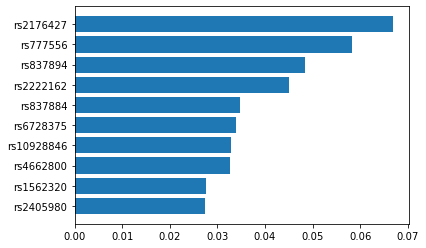

In [22]:
# Plotting features that random forest classifier found important

rf =  pd.DataFrame({"featrue": idf.columns, "importance":rfc.feature_importances_})
sorted_idx = rfc.feature_importances_.argsort()
plt.barh(idf.columns[sorted_idx[-10:]], rfc.feature_importances_[sorted_idx[-10:]])

In [23]:
# Finding hyperparameters for KNN


# leafSize = list(range(1,30))
# neighbours = list(range(1,30))
# p = [1,2]
# hyperparameters = dict(leaf_size=leafSize, n_neighbors=neighbours, p=p)

# knn = KNeighborsClassifier() 

# clf = GridSearchCV(knn, hyperparameters, cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best leaf_size:', bestModel.best_estimator_.get_params()['leaf_size'])
# print('Best p:', bestModel.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', bestModel.best_estimator_.get_params()['n_neighbors'])

In [24]:
# Classifying GWAS data using KNN and printing results

knnClf = KNeighborsClassifier(leaf_size=1, n_neighbors=22,p=2 ) 
knnClf.fit(xTrain, yTrain)
yPredicted = knnClf.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = knnClf.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.6037735849056604
Testing accuracy score: 0.4722222222222222
[[ 8 13]
 [ 6  9]]


In [25]:
# Finding hyperparameters for KNN

# C = [0.1,1, 10, 100]
# gamma = [1,0.1,0.01,0.001]
# kernel = ['rbf', 'poly', 'sigmoid']
# hyperparameters = dict(C=C,gamma=gamma,kernel=kernel)

# SVM = SVC()

# clf = GridSearchCV(SVM, hyperparameters, refit=True,cv=10)

# bestModel = clf.fit(idf, phenotype)
# print('Best C:', bestModel.best_estimator_.get_params()['C'])
# print('Best gamma:', bestModel.best_estimator_.get_params()['gamma'])
# print('Best kernel:', bestModel.best_estimator_.get_params()['kernel'])

In [26]:
# Classifying GWAS data using sigmoid SVC and printing results

SVM = SVC(kernel="sigmoid", C=100, gamma=0.001)
SVM.fit(xTrain, yTrain)
yPredicted = SVM.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = SVM.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.9245283018867925
Testing accuracy score: 0.4166666666666667
[[ 6 15]
 [ 6  9]]


In [27]:
# Classifying GWAS data using sigmoid SVC and printing results

RCLF = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
RCLF.fit(xTrain, yTrain)
yPredicted = RCLF.predict(xTrain)
print("Training accuracy score: {}".format(accuracy_score(yTrain, yPredicted)))
yPredicted = RCLF.predict(xTtest)
print("Testing accuracy score: {}".format(accuracy_score(yTest, yPredicted)))
print(confusion_matrix(yTest, yPredicted))

Training accuracy score: 0.7924528301886793
Testing accuracy score: 0.5
[[ 5 16]
 [ 2 13]]


In [28]:
# Converting df columns into 2d numpy array time series

idf = idf.apply(pd.to_numeric)
idfSeries = from_2d_array_to_nested(idf)

In [29]:
# Splitting time seriesdata into training data and testing data

xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)

In [30]:
# Extracting values from training split

yTrain = yTrain.values
yTest = yTest.values

xTrain = xTrain.reset_index()
xTrain = xTrain.drop(columns=["index"])

xTest = xTest.reset_index()
xTest = xTest.drop(columns=["index"])

In [31]:
# Running rocket kernal transformation on training data

rocket = Rocket()
rocket.fit(xTrain)
xTrainTransform = rocket.transform(xTrain)

In [32]:
# Classifying GWAS Data from rocket transformation using Ridge Classifier

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(xTrainTransform, yTrain)
xTestTransform = rocket.transform(xTest)
yPredict = classifier.predict(xTestTransform)
print("Accuracy with Rocket: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with Rocket: 0.500
[[ 5 16]
 [ 2 13]]
              precision    recall  f1-score   support

        case       0.71      0.24      0.36        21
     control       0.45      0.87      0.59        15

    accuracy                           0.50        36
   macro avg       0.58      0.55      0.47        36
weighted avg       0.60      0.50      0.45        36



In [33]:
# Classifying GWAS data using MrSEQL

ms = MrSEQLClassifier(seql_mode="clf")
ms.fit(xTrain, yTrain)
yPredict = ms.predict(xTest)
print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
print(confusion_matrix(yTest, yPredict))
print(classification_report(yTest, yPredict))

Accuracy with MrSEQL: 0.667
[[12  9]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.80      0.57      0.67        21
     control       0.57      0.80      0.67        15

    accuracy                           0.67        36
   macro avg       0.69      0.69      0.67        36
weighted avg       0.70      0.67      0.67        36



In [34]:
# Method to setup df for testing

def SetupTest(df):
    imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
    idf = pd.DataFrame(imp.fit_transform(df))
    idf.columns = df.columns
    idf = idf.apply(pd.to_numeric)
    return idf

In [35]:
# Method to generate graph that displays change in accuracy for a given classifier as the length of the target SNP
#    is increasde

def GenerateSignalGraph(df, classifier):
    
    results = []
    dfTest = df.copy(deep=True)
    phenotype = dfTest.pop("PHENOTYPE")
    dfTest = dfTest.drop(columns=["FID","IID","PAT","MAT","SEX"])
    for n in range(1,10):
        classifierTemp = clone(classifier)
        dfTest.insert(dfTest.columns.get_loc("rs2222162"), f"rs222216_{n}", dfTest["rs2222162"])
        idf = SetupTest(dfTest)
        xTrain, xTest, yTrain, yTest = train_test_split(idf, phenotype, train_size=0.6, random_state=1)
        classifierTemp.fit(xTrain, yTrain)
        yPredict = classifierTemp.predict(xTest)
        results.append(metrics.accuracy_score(yTest, yPredict))
        
        if n == 9:
            print(f"Accuracy with 10 length signal: {metrics.accuracy_score(yTest, yPredict)}")
            print(confusion_matrix(yTest, yPredict))
            print(classification_report(yTest, yPredict))
            
    plt.plot(results)

Accuracy with 10 length signal: 0.6388888888888888
[[11 10]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.79      0.52      0.63        21
     control       0.55      0.80      0.65        15

    accuracy                           0.64        36
   macro avg       0.67      0.66      0.64        36
weighted avg       0.69      0.64      0.64        36



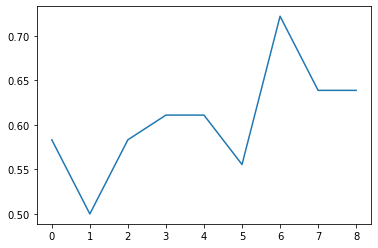

In [36]:
# Plotting change in accuracy for increased signal length for Random Forst

rfc = RandomForestClassifier(bootstrap=True, max_depth=100, max_features="sqrt", 
                             min_samples_leaf=4, min_samples_split=2, n_estimators=100)
GenerateSignalGraph(dfSave, rfc)

Accuracy with 10 length signal: 0.7222222222222222
[[16  5]
 [ 5 10]]
              precision    recall  f1-score   support

        case       0.76      0.76      0.76        21
     control       0.67      0.67      0.67        15

    accuracy                           0.72        36
   macro avg       0.71      0.71      0.71        36
weighted avg       0.72      0.72      0.72        36



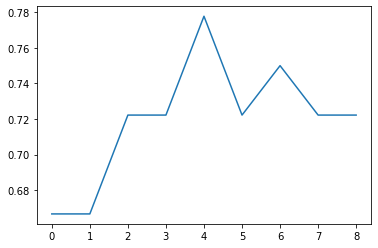

In [37]:
# Plotting change in accuracy for increased signal length for Knn

knnClf = KNeighborsClassifier(leaf_size=1, n_neighbors=22,p=2 ) 
GenerateSignalGraph(dfSave, knnClf)

Accuracy with 10 length signal: 0.6111111111111112
[[12  9]
 [ 5 10]]
              precision    recall  f1-score   support

        case       0.71      0.57      0.63        21
     control       0.53      0.67      0.59        15

    accuracy                           0.61        36
   macro avg       0.62      0.62      0.61        36
weighted avg       0.63      0.61      0.61        36



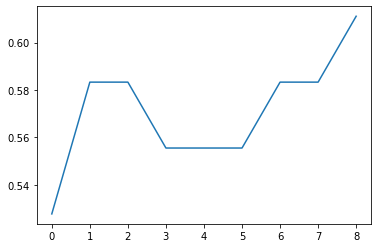

In [38]:
# Plotting change in accuracy for increased signal length for SVM

SVM = SVC(kernel="sigmoid", C=100, gamma=0.001)
GenerateSignalGraph(dfSave, SVM)

Accuracy with 10 length signal: 0.6666666666666666
[[12  9]
 [ 3 12]]
              precision    recall  f1-score   support

        case       0.80      0.57      0.67        21
     control       0.57      0.80      0.67        15

    accuracy                           0.67        36
   macro avg       0.69      0.69      0.67        36
weighted avg       0.70      0.67      0.67        36



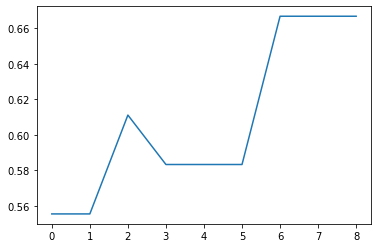

In [39]:
results = []
dfTest = dfSave.copy(deep=True)
phenotype = dfTest.pop("PHENOTYPE")
dfTest = dfTest.drop(columns=["FID","IID","PAT","MAT","SEX"])

for n in range(1,10):
    
    dfTest.insert(dfTest.columns.get_loc("rs2222162"), f"rs222216_{n}", dfTest["rs2222162"])
    idf = SetupTest(dfTest)
    idfSeries = from_2d_array_to_nested(idf)
    
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)
    
    yTrain = yTrain.values
    yTest = yTest.values

    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])

    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    rocket = Rocket()
    rocket.fit(xTrain)
    xTrainTransform = rocket.transform(xTrain)
    
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)
    xTestTransform = rocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)
    results.append(metrics.accuracy_score(yTest, yPredict))
    
    if n == 9:
        print(f"Accuracy with 10 length signal: {metrics.accuracy_score(yTest, yPredict)}")
        print(confusion_matrix(yTest, yPredict))
        print(classification_report(yTest, yPredict))
    
_ = plt.plot(results)

In [ ]:
results = []
dfTest = dfSave.copy(deep=True)
phenotype = dfTest.pop("PHENOTYPE")
dfTest = dfTest.drop(columns=["FID","IID","PAT","MAT","SEX"])
idf=None
for n in range(1,10):
    
    dfTest.insert(dfTest.columns.get_loc("rs2222162"), f"rs2222162_{n}", dfTest["rs2222162"])
    idf = SetupTest(dfTest)
    idfSeries = from_2d_array_to_nested(idf)
    
    xTrain, xTest, yTrain, yTest = train_test_split(idfSeries, phenotype, train_size=0.6, random_state=1)
    
    yTrain = yTrain.values
    yTest = yTest.values

    xTrain = xTrain.reset_index()
    xTrain = xTrain.drop(columns=["index"])

    xTest = xTest.reset_index()
    xTest = xTest.drop(columns=["index"])
    
    ms = MrSEQLClassifier(seql_mode="clf")
    ms.fit(xTrain, yTrain)
    yPredict = ms.predict(xTest)
    results.append(metrics.accuracy_score(yTest, yPredict))
    
    if n == 9:
        print(f"Accuracy with 10 length signal: {metrics.accuracy_score(yTest, yPredict)}")
        print(confusion_matrix(yTest, yPredict))
        print(classification_report(yTest, yPredict))
    
_ = plt.plot(results)

In [ ]:
idfT = idf.T
position = idfT[8].index.get_loc("rs2222162")
plt.xticks([])
plt.plot(idfT[8][0:position-1], color="tab:blue")
plt.plot(idfT[8][position-2:position+1], color="red")
plt.plot(idfT[8][position:],color="tab:blue")
phenotype[position], idfT[8][position]

In [ ]:
idfT[8].to_string()